# Coursework 1 - Mathematics for Machine Learning

## Due: 25/03/2025

## CID: insert your CID here

***
***

## Exercise 1: Quick questions [2 points]

#### Question 1:

Enter your answer here

#### Question 2:

Enter your answer here

#### Question 3:

Enter your answer here

#### Question 4:

Enter your answer here

*** 
***

## Exercise 2: [6 points]


### Question 1 [2 points]


***

### Question 2 [2 points]

***

### Question 3 [2 points]

***
***

## Exercise 3: Implementation [13 points]

In [1]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Part 1: Image classification [4 points]

***
### Question 1 [0.5 point]


Download the dataset from
https://chaladze.com/l5/img/Linnaeus%205%2032X32.rar
and uncompress the .rar dataset to a folder named "Linnaeus_5_32X32" in the current directory.
This folder contains a subfolder "Linnaeus 5 32X32", which contains a test and a train folder with the images of the dataset in 5 different classes: berry, bird, dog, flower, other.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32\\Linnaeus 5 32X32\\train", transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32\\Linnaeus 5 32X32\\test", transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False,)

classes = ('berry', 'bird', 'dog', 'flower', 'other')

In [3]:
trainset.classes

['berry', 'bird', 'dog', 'flower', 'other']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.7647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.827451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.92156863].


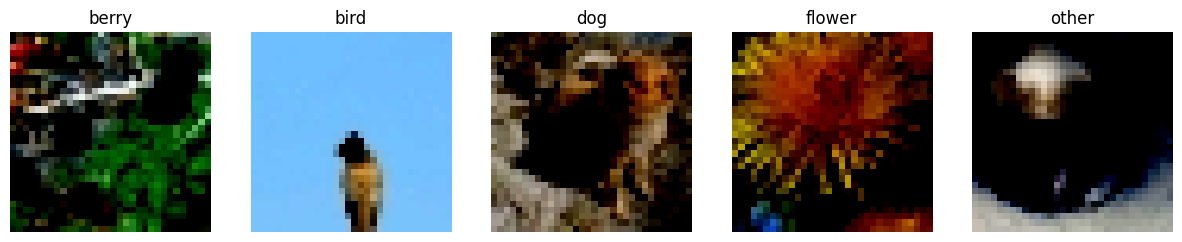

In [4]:
to_display = {cls: None for cls in trainset.classes}
idx_to_class = {i: c for c, i in trainset.class_to_idx.items()}
i = 0
j = 0
for img, label in trainset:
    if to_display[idx_to_class[label]] is None:
        to_display[idx_to_class[label]] = img
        i += 1
    if i >= len(trainset.classes):
        break

fig, axs = plt.subplots(1, len(trainset.classes), figsize=(15, 3))
for i in range(len(trainset.classes)):
    cls = trainset.classes[i]
    axs[i].imshow(to_display[cls].numpy().transpose(1, 2, 0))
    axs[i].axis('off')
    axs[i].set_title(cls)
plt.show()

### Question 2 [0.5 point]

```
transform = transforms.Compose([
    transforms.ToTensor (),W
    transforms . Normalize ((0.5 , 0.5 , 0.5) , (0.5 , 0.5 , 0.5)
)]
```
The above transform first takes an input image (either a PIL image or numpy array of shape (H, W, C)) and converts it into a torch tensor of shape (C, H, W) whilst scaling from [0, 255] to [0, 1]. Then the normalise transform applies channel-wise normalisation for each pixel. It computes $x_{norm} = \frac{x-0.5}{0.5}$. This transforms the pixel ranges from [0, 1] to [-1, 1].


***
### Question 3 [1 point]

In [5]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=4096, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=5)

        self.relu = nn.ReLU()

    def forward(self, x):
        # cnn
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.mp1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.mp2(x)
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.mp3(x)

        # flatten
        x = x.view(-1, 4096)

        # fcn
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

***
### Question 4 [0.5 point]

In [6]:
import torchsummary

torchsummary.summary(myCNN(), (3, 32, 32))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

***
### Question 5 [0.5 point]

In [18]:
def train(myCNN, nr_epochs, optimizer ,criterion, trainloader):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion.to(device)


    for epoch in range(nr_epochs):
        for inputs, labels in trainloader:
            optimizer.zero_grad()

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = myCNN(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()


        if epoch % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, nr_epochs, loss.item()))

    model.to('cpu')
    criterion.to('cpu')

***
### Question 6 [0.5 point]

In [19]:
model = myCNN()

n_epochs = 30
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train(model, n_epochs, optim, criterion, trainloader)

Epoch [0/30], Loss: 1.4583


KeyboardInterrupt: 

***
### Question 7 [0.5 point]

***
## Part 2: Fine-tuning a pretrained model [3.5 points]

### Question 1 [0.5 point]

***
### Question 2 [1 point]

***
### Question 3 [0.5 point]

***
### Question 4 [0.5 point]

***
### Question 5 [1 point]

***
## Part 3: Adversarial attacks [4.5 points]

***
### Question 1 [1 point]

***
### Question 2 [1 point]

***
### Question 3 [0.5 point]

***
### Question 4 [0.5 point]

***
### Question 5 [1 point]

***
### Question 6 [0.5 point]